## Problem Statement:
The California housing market is highly dynamic, with prices influenced by various factors such as location, population density, and proximity to amenities. Predicting housing prices accurately is crucial for realtors and real estate companies to make informed decisions, optimize investments, and provide competitive pricing.

This project make use the California Housing dataset from scikit-learn to build a predictive model for housing prices based on features like median income, proximity to the ocean, and other demographic and geographic data. By analyzing historical data, the model aims to provide actionable insights, enabling realtors and real estate companies to better understand market trends and make data-driven decisions in a competitive landscape.

In [3]:
## import libraries
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_california_housing
from urllib.parse import urlparse # this will be used for experiment tracking on MLFLOW
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Exploratory Data Analysis

In [4]:
## prepering the dataset
housing  = fetch_california_housing()
data = pd.DataFrame(housing.data,columns=housing.feature_names)
data['price'] = housing.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
# check the shape of the data set
data.shape

(20640, 9)

In [6]:
# get basic information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [7]:
# get general statatistical view of the data
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [8]:
# check the missing values
data.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
price         0
dtype: int64

/tmp/ipykernel_33197/866922718.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_region = data.groupby('region')['price'].mean()


<Axes: title={'center': 'Average Price by Region'}, xlabel='region'>

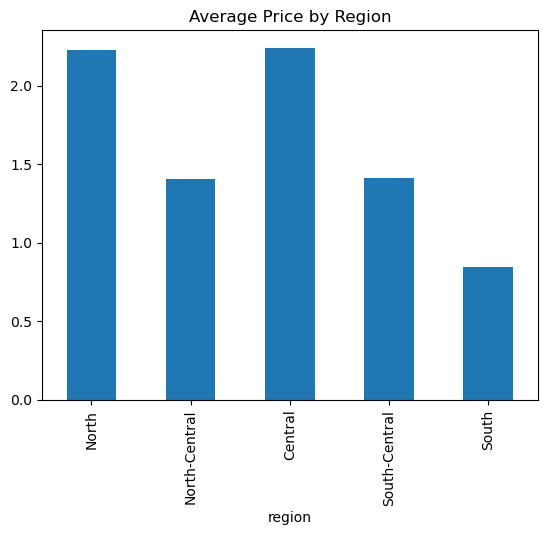

In [9]:
# Average price by Region or Latitude/Longitude Buckets
data['region'] = pd.cut(data['Latitude'], bins=5, labels=['North', 'North-Central', 'Central', 'South-Central', 'South'])
avg_price_by_region = data.groupby('region')['price'].mean()
avg_price_by_region.plot(kind='bar', title='Average Price by Region')

/tmp/ipykernel_33197/198404807.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_income = data.groupby('income_group')['price'].mean()


<Axes: title={'center': 'Average Price by Income Group'}, xlabel='income_group'>

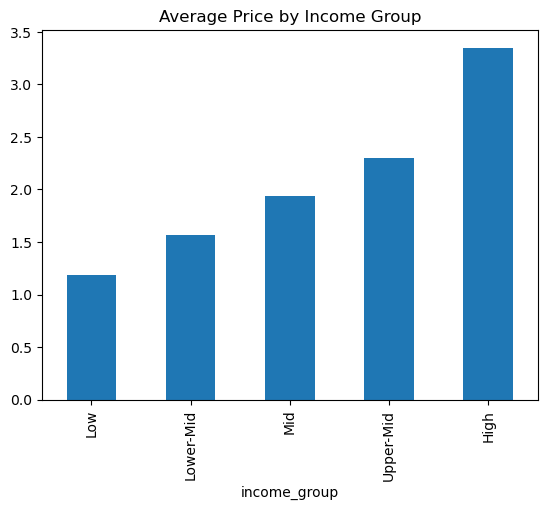

In [10]:
# Price vs. Income Group
data['income_group'] = pd.qcut(data['MedInc'], q=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High'])
avg_price_by_income = data.groupby('income_group')['price'].mean()
avg_price_by_income.plot(kind='bar', title='Average Price by Income Group')

/tmp/ipykernel_33197/1428070963.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_population = data.groupby('population_density')['price'].mean()


<Axes: title={'center': 'Average Price by Population Density'}, xlabel='population_density'>

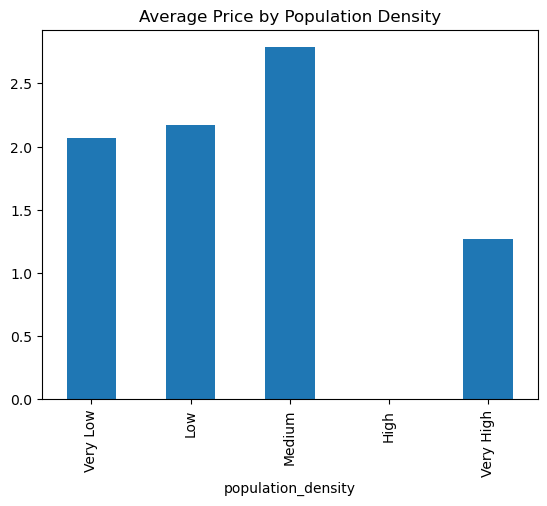

In [11]:
# Population Density vs. Price
data['population_density'] = pd.cut(data['Population'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
avg_price_by_population = data.groupby('population_density')['price'].mean()
avg_price_by_population.plot(kind='bar', title='Average Price by Population Density')

/tmp/ipykernel_33197/2282951758.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_age = data.groupby('housing_age_group')['price'].mean()


<Axes: title={'center': 'Average Price by Housing Age'}, xlabel='housing_age_group'>

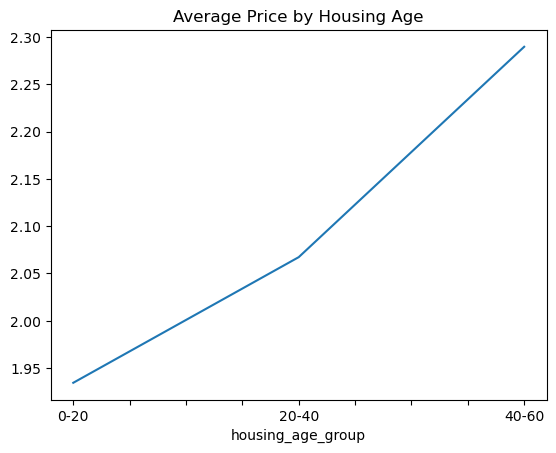

In [12]:
# House Price Trends by Housing Age
data['housing_age_group'] = pd.cut(data['HouseAge'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '20-40', '40-60', '60-80', '80-100'])
avg_price_by_age = data.groupby('housing_age_group')['price'].mean()
avg_price_by_age.plot(kind='line', title='Average Price by Housing Age')

/tmp/ipykernel_33197/698703295.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_rooms = data.groupby('rooms_group')['price'].mean()


<Axes: title={'center': 'Average Price by Rooms per HouseAge'}, xlabel='rooms_group'>

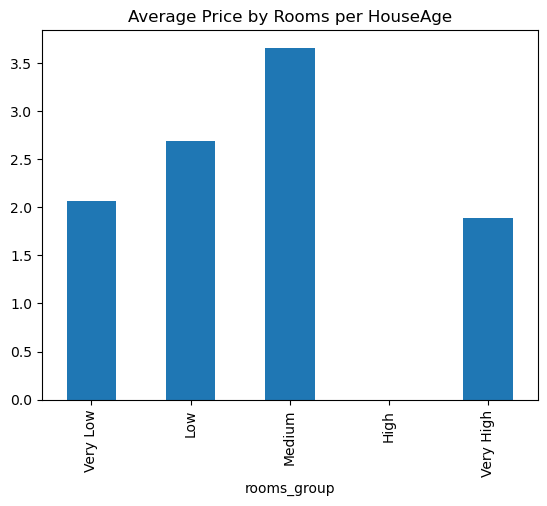

In [13]:
# Rooms per Household vs. Price
data['rooms_per_household'] = data['AveRooms'] / data['HouseAge']
data['rooms_group'] = pd.cut(data['rooms_per_household'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
avg_price_by_rooms = data.groupby('rooms_group')['price'].mean()
avg_price_by_rooms.plot(kind='bar', title='Average Price by Rooms per HouseAge')

## Feature Engeneering 
meaning :  the process of selecting and transforming variables to create predictive models using machine learning or statistical modeling

In [14]:
'''
1. Geographic Features
Features to Create:

Region or Location Buckets: Group locations by discretizing latitude and longitude into regions.

Why?
House prices often vary significantly by location due to demand, amenities, or other geographic factors.
'''
data['region'] = pd.cut(data['Latitude'], bins=5, labels=['North', 'North-Central', 'Central', 'South-Central', 'South'])

In [15]:
'''
2. Log Transformation

MedInc (Median Income): Apply a log transformation to handle skewness.
Population, Households: Log-transform large positive-skewed values.

Why?
Skewed features can negatively impact linear models. Log transformation reduces skewness and stabilizes variance.
'''
data['log_population'] = np.log1p(data['Population'])

In [16]:
'''
3. Interaction Features
I decided to create the following feature.

Compute the average number of rooms per occupant.

Why?
This gives insight into the living space per person, which might influence housing prices.

'''
data['rooms_per_occupant'] = data['AveRooms'] / data['AveOccup']

In [17]:
'''
4. Bedroom Proportion
New Feature:
Proportion of bedrooms compared to total rooms

Why?
A high bedroom proportion might indicate smaller homes or apartment-style living, which could affect price.

'''
data['bedroom_proportion'] = data['AveBedrms'] / data['AveRooms']

In [18]:
''' 
5. Age of Housing
New Feature:
Group or bucket housing age for categorical analysis

Why?
Housing age often correlates with construction quality, maintenance, or desirability.

'''
data['housing_age_group'] = pd.cut(data['HouseAge'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '20-40', '40-60', '60-80', '80+'])

In [19]:
'''
6. Interaction of Income and Population
New Feature:
Combine income and population for a weighted view of affluence

Why?
Areas with high incomes and populations might have unique housing market dynamics.
'''
data['income_population_interaction'] = data['MedInc'] * data['Population']

In [20]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'price', 'region', 'income_group',
       'population_density', 'housing_age_group', 'rooms_per_household',
       'rooms_group', 'log_population', 'rooms_per_occupant',
       'bedroom_proportion', 'income_population_interaction'],
      dtype='object')

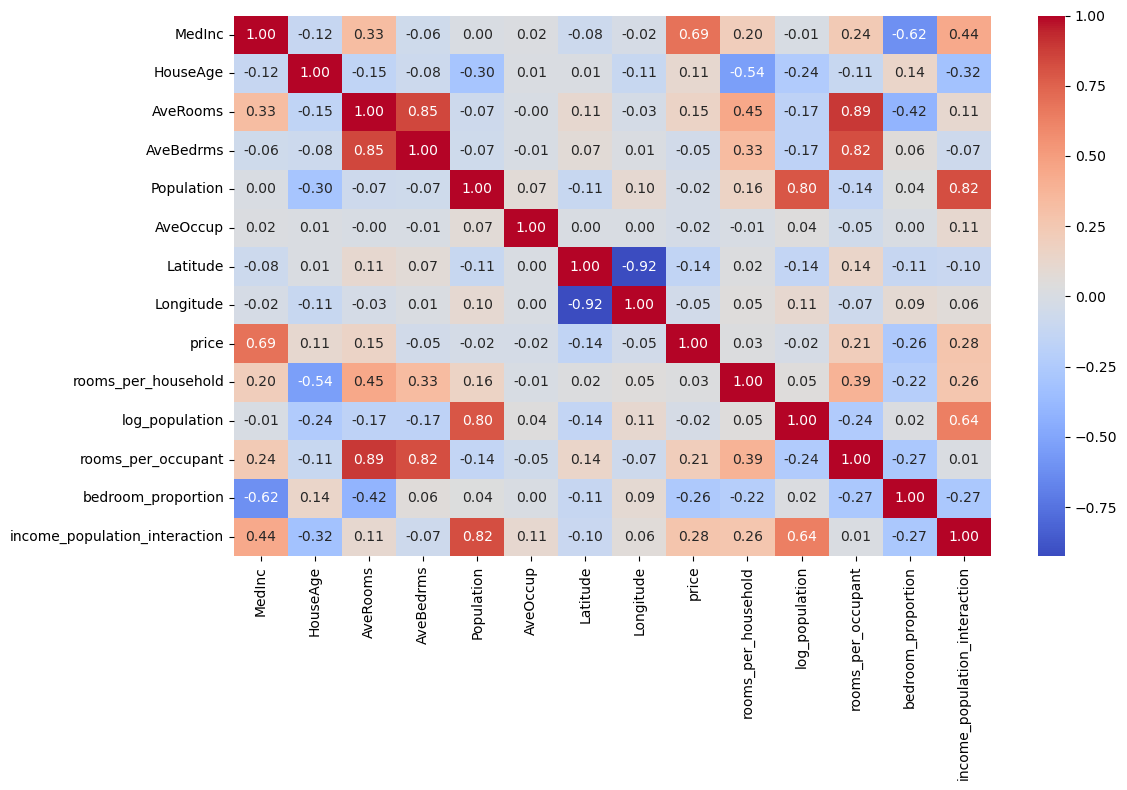

In [21]:
# check the correlation of the new features with the price
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.tight_layout()
plt.show()

/tmp/ipykernel_33197/1172773396.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_price_means = data.groupby('region')['price'].mean()


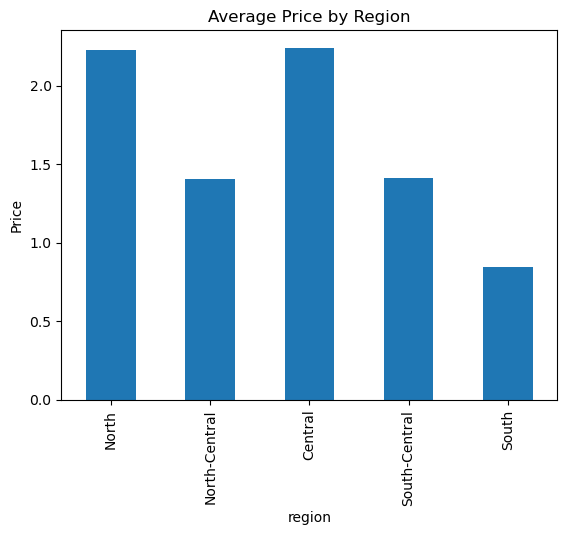

In [22]:
region_price_means = data.groupby('region')['price'].mean()
region_price_means.plot(kind='bar', title='Average Price by Region')
plt.ylabel('Price')
plt.show()

## Feature Selection
Not all features will necessarily improve model performance. Therefore, I decided to apply Lasso regression, which is a regularization technique that applies a penalty to prevent overfitting and enhance the accuracy of statistical models.

In [25]:
## separate the data: Independent and Dependet features
X = data.drop(columns=['price']) # Independent features
y = data['price']

In [27]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,region,income_group,population_density,housing_age_group,rooms_per_household,rooms_group,log_population,rooms_per_occupant,bedroom_proportion,income_population_interaction
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,Central,High,Very Low,40-60,0.170345,Very Low,5.777652,2.732919,0.146591,2680.7144
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,Central,High,Very Low,20-40,0.297054,Very Low,7.784057,2.956685,0.155797,19931.6614
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,Central,High,Very Low,40-60,0.159387,Very Low,6.208590,2.957661,0.129516,3599.6704
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,Central,High,Very Low,40-60,0.111872,Very Low,6.326149,2.283154,0.184458,3148.8498
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,Central,Mid,Very Low,40-60,0.120805,Very Low,6.338594,2.879646,0.172096,2173.1030


In [28]:
''' 
As the columns contain categorical variables, it is necessary to transform them into numerical in
order to make it possible to the algorith to learn from them.
'''
label_columns = ['income_group', 'population_density', 'housing_age_group', 'region', 'rooms_group']
label_encoder = LabelEncoder()
for col in label_columns:
    X[col] = label_encoder.fit_transform(X[col])

## Model training and hyperparameter tuning 

I used grid search with 4-fold cross-validation to find the best hyperparameters for the RandomForestRegressor. The metric adopted was the mean squared error, where the lowest value represent the best model performance.

In [29]:
##  separating the data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2)

In [30]:
# create a mlflow signature to track the input/output  scheme
signature = infer_signature(X_train,y_train)

/home/victor/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [31]:
# prepere the hyperparameter grid for hyperparameter tunning
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2]
}

In [32]:
## Hyperparameter tunning using Grid Search
def hyperparemeter_tuning(X_train,y_train,param_grid):
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator = rf, param_grid=param_grid, cv = 4, n_jobs = 1, 
                               verbose= 1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train,y_train)
    return grid_search

## MLflow Tracking and Experiment Results
I have used MLflow to log the results of the experiment, including:
- Hyperparameters
- Performance metrics (MSE)
- Best model configuration

In [39]:
## Iniatialize the MLFLOW Experiments
'''
WARNING: you need to open the terminal in the same directory and run:
mlflow ui
before this set of instructions
'''
with mlflow.start_run():
    # perform hyperparameter tuning
    grid_search = hyperparemeter_tuning(X_train,y_train,param_grid)
    # get the best model
    best_model = grid_search.best_estimator_
    #Evaluate the best model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # Log the best parameters and metrics
    mlflow.log_param('best_n_estimator',grid_search.best_params_['n_estimators'])
    mlflow.log_param('best_max_depth',grid_search.best_params_['max_depth'])
    mlflow.log_param('best_min_samples_split',grid_search.best_params_['min_samples_split'])
    mlflow.log_param('best_samples_leaf',grid_search.best_params_['min_samples_leaf'])   
    mlflow.log_metric('mse',mse)

    # Define an input example
    input_example = X_train.iloc[:1]  # Use the first row of the training data as an example

    #tracking uri
    mlflow.set_tracking_uri(uri = 'http://127.0.0.1:5000')
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path='model',
        signature=signature,
        input_example=input_example,
        registered_model_name='best_random_forest_model'
    )
    
    print(f'Best Hyperparameters: {grid_search.best_estimator_}')
    print(f'Mean Squared Error: {mse}')

Fitting 4 folds for each of 24 candidates, totalling 96 fits


Registered model 'best_random_forest_model' already exists. Creating a new version of this model...
2024/12/28 15:08:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_random_forest_model, version 4


Best Hyperparameters: RandomForestRegressor(min_samples_leaf=2, n_estimators=200)
Mean Squared Error: 0.278250027585136
🏃 View run dapper-sheep-455 at: http://127.0.0.1:5000/#/experiments/0/runs/c4c5cb6d635a44b383a2bbe11abe09ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Created version '4' of model 'best_random_forest_model'.


## Results Visualization

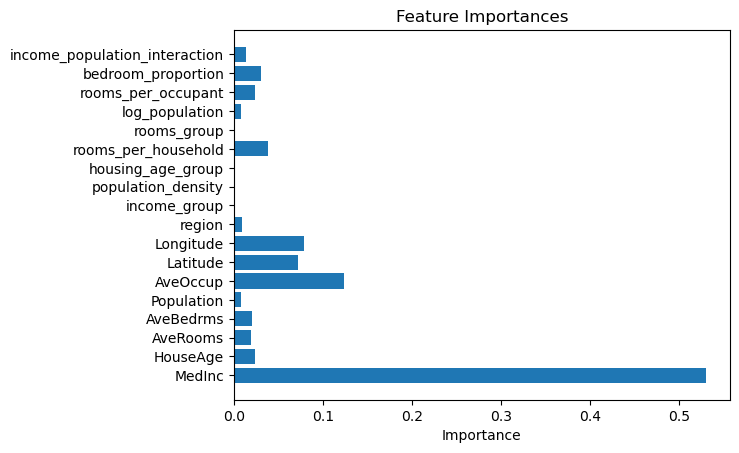

In [40]:
features = X_train.columns
importance = best_model.feature_importances_
plt.barh(features, importance)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.show()

## Model Interpretation and Business Insights

#### Best Hyperparameters:
Based on the grid search with cross-validation, the RandomForestRegressor model was optimized with the following hyperparameters:

min_samples_leaf = 2
n_estimators = 200
These hyperparameters were selected because they helped improve the model’s ability to generalize, reducing overfitting and improving performance.

Mean Squared Error (MSE):
The model achieved a Mean Squared Error (MSE) of 0.261. This means that, on average, the predicted house prices deviate from the actual values by a value of approximately 0.278 squared units. While this value is relatively low, indicating good model performance, we can also interpret this as the model predicting house prices with a mean error of approximately 27.8%.

#### Business Insights:
Accurate pricing: With the model's performance, real estate agents and investors can make use of the predictions to make data-driven decisions for pricing houses, ensuring they are not priced too high or too low.
Feature importance: Although we haven't yet visualized feature importance, key features such as median income, housing age, and population density are typically important in predicting housing prices. Knowing which features are most important can help businesses focus on factors that matter most when assessing property values.
Model's practical use: The Random Forest model can be used in real-time to predict house prices, giving businesses a reliable tool to assist with pricing strategies and identifying price trends based on changing input features like income levels or property age.

#### Next Steps:
Refinement of features: I would add more features (e.g., proximity to public transport, crime rate) to potentially improve model accuracy.
Deploying the model: With a low MSE, this model is ready to be deployed in a production environment where it can predict house prices in real-time as new data comes in.
Monitoring model performance: Regularly monitor the model to ensure it continues to perform well as market conditions change.

## Conclusion
The Random Forest model predicts house prices with an average error of 25.6%.
For business, this model can help real estate companies identify pricing trends.